In [9]:
from constants import*
from functions import*
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

dataFolder = 'data/'

## Treat DOD data

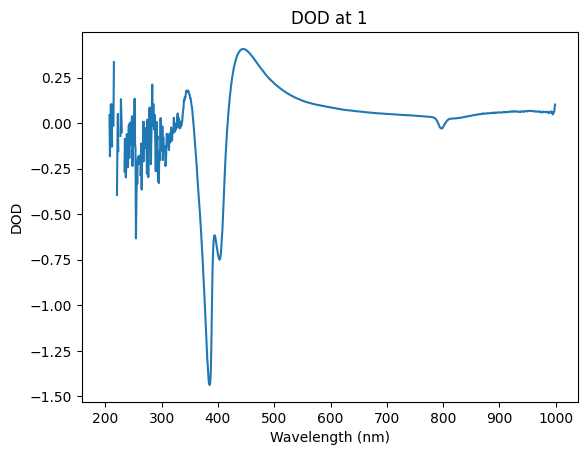

In [10]:
#I handle Inf and NaN, replacing them with np.nan as they're treated as float and not mere strings.
DODtestDF = pd.read_csv(dataFolder+'TASavgMatrix.csv', header = None, na_values=["Inf", "-Inf", "NaN"])
DODtestDF.replace([np.inf, -np.inf], np.nan, inplace=True)
#np.searchsorted() needs arrays in order, so I inverted the lambda axis
DODwavelength = DODtestDF.iloc[1:,0].to_numpy(dtype=float)
DODdelay = DODtestDF.iloc[0,1:].to_numpy(dtype=float)
DODspectrum = DODtestDF.iloc[1:,1:].to_numpy(dtype=float)

testDelay = 1
delayIndex = np.searchsorted(DODdelay, testDelay, side="left")
closestTime = DODdelay[delayIndex]
singleDelaySpectrum = DODspectrum[:,delayIndex]

DODwavelength, singleDelaySpectrum = funcCheckAxisOrder(DODwavelength, singleDelaySpectrum)

Figure, ax=plt.subplots()
plt.title('DOD at {:.4g}' .format(closestTime))
ax.plot(DODwavelength, singleDelaySpectrum)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('DOD')
plt.show()

I need to remove the scattered light. In order to do so, I plot data at a $\tau<0$ so the peak shown corresponds only to the scattered light. Notice it may be positive or negative, since the light fluctuates and averging over the data when getting the baseline can't get rid of scattered light. 

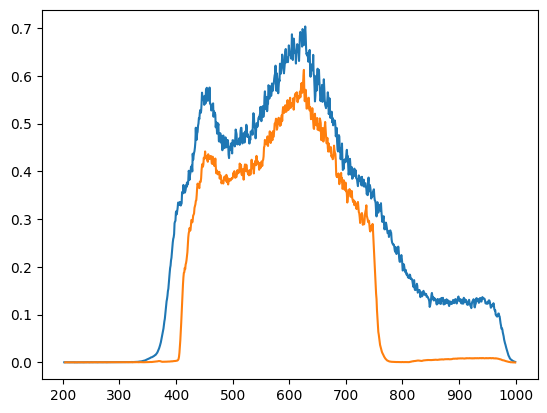

In [11]:
whiteLightFile = '1748whiteLightRef.txt'
whiteLightFilteredFile ='1748whiteLightRefFiltered.txt'


whiteLightData = np.loadtxt(dataFolder+whiteLightFile)
whiteLightFilteredData = np.loadtxt(dataFolder+whiteLightFilteredFile)
whiteLightWavelength = whiteLightData[:,0][::-1]
whiteLight = whiteLightData[:,1][::-1]
whiteLightWavelengthFiltered = whiteLightFilteredData[:,0][::-1]
whiteLightFiltered = whiteLightFilteredData[:,1][::-1]



Figure, ax = plt.subplots()
ax.plot(whiteLightWavelength, whiteLight)
ax.plot(whiteLightWavelengthFiltered, whiteLightFiltered)
#ax.set_ylim(0,0.05)
plt.show()

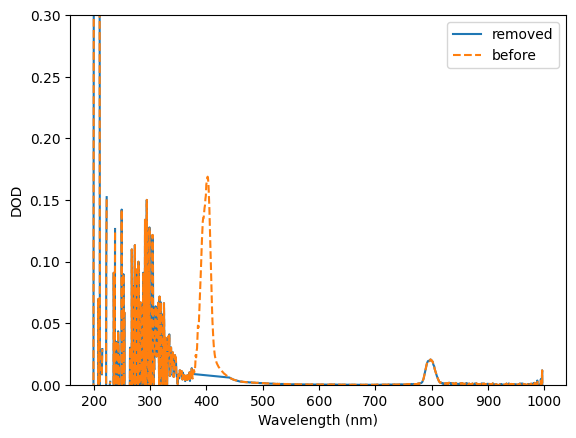

In [ ]:
baselineDelay = -5

lowCut = 375
highCut = 440

#lowCutIndex = np.searchsorted(DODwavelength, lowCut, side="left")
#highCutIndex = np.searchsorted(DODwavelength, highCut, side="right")

#DODwavelengthTrimmed = np.delete(DODwavelength, np.arange(lowCutIndex,highCutIndex+1))

baselineDelayIndex = np.searchsorted(DODdelay, baselineDelay, side="left")
baselineClosestTime = DODdelay[baselineDelayIndex]
baselineDelaySpectrum = DODspectrum[:,baselineDelayIndex][::-1]
#baselineDelaySpectrumTrimmed = np.delete(baselineDelaySpectrum, np.arange(lowCutIndex,highCutIndex+1))

DODwavelengthTrimmed, baselineDelaySpectrumTrimmed = funcDataTrimmer(DODwavelength, baselineDelaySpectrum, lowCut, highCut)

Figure, ax=plt.subplots()
plt.title()
ax.plot(DODwavelengthTrimmed, baselineDelaySpectrumTrimmed, label = 'removed')
ax.plot(DODwavelength, baselineDelaySpectrum, linestyle = '--', label='before')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('DOD')
#ax.set_xlim(350, 500)
ax.set_ylim(0,0.3)
ax.legend()
plt.show()

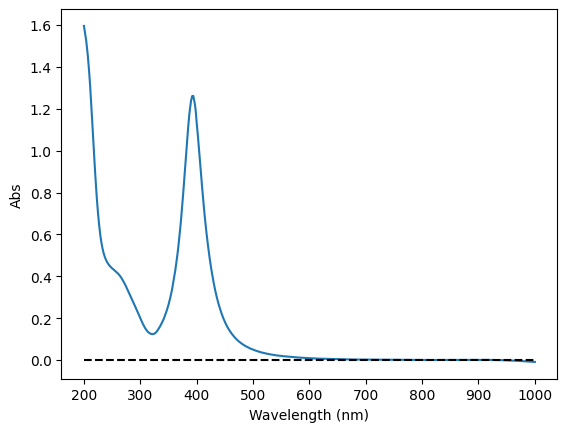

In [13]:
UVvisData = np.loadtxt(dataFolder+'absorbance30uJafter.csv', delimiter = ',')
UVvisDataWavelength,UVvisDataSpectrumB = funcCheckAxisOrder(UVvisData[:,0],UVvisData[:,1])
UVvisDataSpectrum = UVvisDataSpectrumB-0.03 #There's a small baseline in the UVvis.

Figure, ax=plt.subplots()
ax.plot(UVvisDataWavelength, UVvisDataSpectrum)
ax.hlines(0, UVvisDataWavelength[0], UVvisDataWavelength[-1], color = 'black', linestyles = '--')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Abs')
plt.show()

In [14]:
sigma = 10
xAxisMax = 100 

UVvisConvoluted, gaussianKernel = convolutionGaussian(UVvisDataSpectrum, sigma, xAxisMax)


I don't know if the convolution affects the x axis, i.e if it stretches it or what. So, assuming the maxima position is preserved, the convolution should give the same difference betweeen maxima indices. That's why I'm looking for the maxima here. 

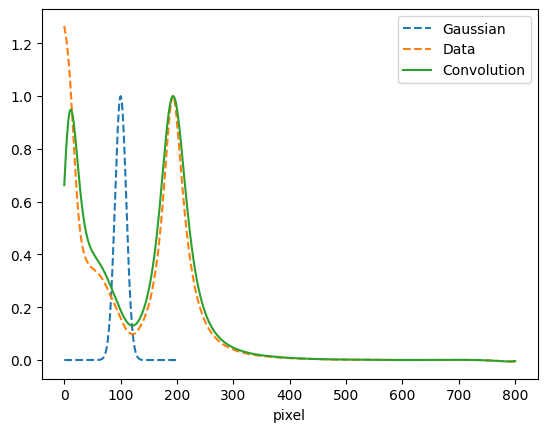

In [15]:
maximums, _ = find_peaks(UVvisDataSpectrum/max(UVvisDataSpectrum), height=0.5 )

Figure, ax = plt.subplots()
ax.plot(range(len(gaussianKernel)), gaussianKernel/max(gaussianKernel), linestyle = '--',label = 'Gaussian')
ax.plot(range(len(UVvisDataSpectrum)), UVvisDataSpectrum/UVvisDataSpectrum[maximums[0]], linestyle = '--', label = 'Data')
ax.plot(range(len(UVvisConvoluted)), UVvisConvoluted/max(UVvisConvoluted), label = 'Convolution')
ax.set_xlabel('pixel')
ax.legend()
plt.show()

## Getting the Product Spectra

Having a few NaN values makes the interpolator return all NaN values, so I first remove all NaN values from the DOD as well as their corresponding wavelengths.

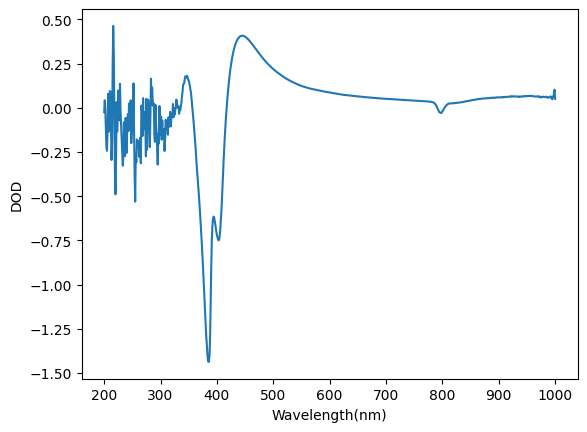

In [ ]:
DODInterpolated = funcInterpolate(DODwavelength, singleDelaySpectrum, UVvisDataWavelength)

Figure, ax = plt.subplots()
ax.plot(UVvisDataWavelength, DODInterpolated)
ax.set_xlabel('Wavelength(nm)')
ax.set_ylabel('DOD')
plt.show()


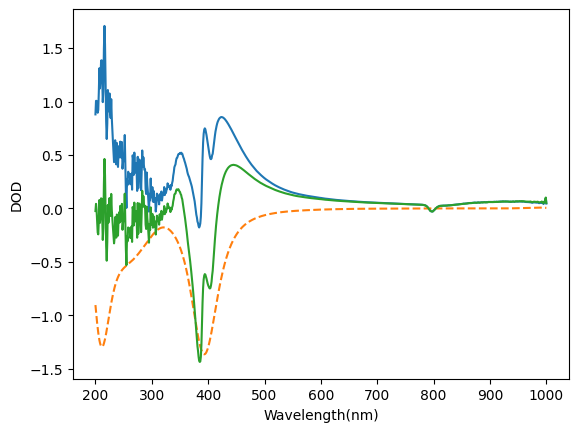

In [26]:
A = 0.05
#productSpectra = (DODwavelength, singleDelaySpectrum, A, UVvisDataWavelength, UVvisConvoluted)
productSpectra = DODInterpolated+A*UVvisConvoluted
#print(productSpectra)

Figure, ax = plt.subplots()
ax.plot(UVvisDataWavelength, productSpectra)
ax.plot(UVvisDataWavelength, -A*UVvisConvoluted, linestyle = '--')
ax.plot(UVvisDataWavelength, DODInterpolated)
ax.set_xlabel('Wavelength(nm)')
ax.set_ylabel('DOD')
plt.show()